[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Smoothing

In [1]:
#format the book
%matplotlib inline
from __future__ import division, print_function
import book_format
book_format.load_style()

## Introduction

It has probably struck you by now that the performance of the Kalman filter is not optimal when you consider future data. For example, suppose we are tracking an aircraft, and the latest measurement is far from the current track, like so (I'll only consider 1 dimension for simplicity):

   10.1 10.2 9.8 10.1 10.2 10.3 10.1 9.9 10.2 10.0 9.9 12.4

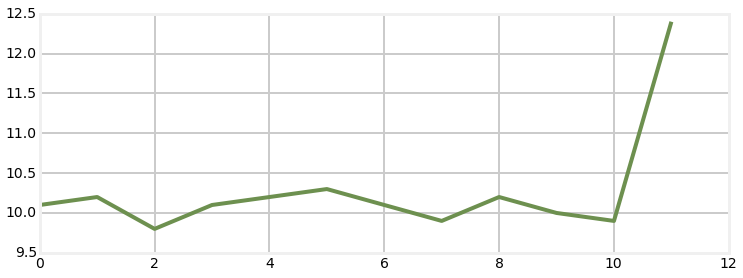

In [2]:
import matplotlib.pyplot as plt

data = [10.1, 10.2, 9.8, 10.1, 10.2, 10.3, 10.1, 9.9, 10.2, 10.0, 9.9, 12.4]
plt.plot(data)
plt.show()

After a long period of near steady state, we have a very large change. Assume that change is larger than the aircraft's maneuvering envelope. Nonetheless the Kalman filter incorporates that new measurement into the filter based on the current Kalman gain. It cannot reject the noise because the measurement could reflect the initiation of a turn. Granted it is unlikely that we are turning so abruptly, but it is impossible to say whether 
    
* The aircraft started a turn awhile ago, but the previous measurements were noisy and didn't show the change.
      
* The aircraft is turning, and this measurement is very noisy
    
* The measurement is very noisy and the aircraft has not turned


Now, suppose the following measurements are:

   11.3 12.1 13.3 13.9 14.5 15.2
   

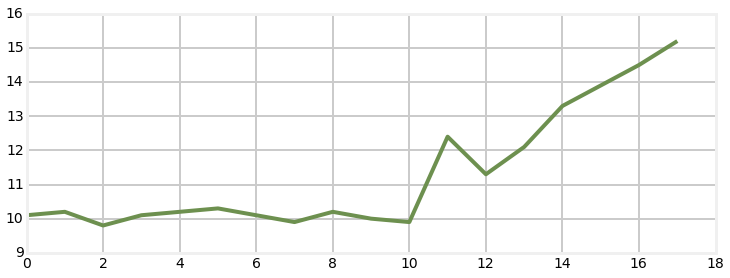

In [3]:
data2 = [11.3, 12.1, 13.3, 13.9, 14.5, 15.2]
plt.plot(data + data2)
plt.show()

   
Given these future measurements we can infer that yes, the aircraft initiated a turn. 

On the other hand, suppose these are the following measurements.

   9.8 10.2 9.9 10.1 10.0 10.3 9.9 10.1
    
In this case we are led to conclude that the aircraft did not turn and that the outlying measurement was merely very noisy. 

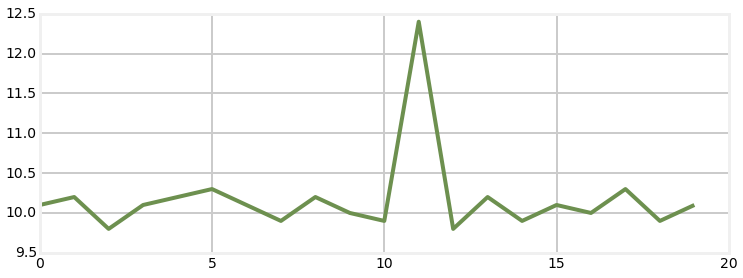

In [4]:
data3 = [9.8, 10.2, 9.9, 10.1, 10.0, 10.3, 9.9, 10.1]
plt.plot(data + data3)
plt.show()

Since this type of smoothing requires knowing data from "the future", there are some applications for the Kalman filter where these observations are not helpful. For example, if we are using a Kalman filter as our navigation filter for an aircraft we have little interest in where we have been. While we could use a smoother to create a smooth history for the plane, we probably are not interested in it. However if we can afford a bit of latency some smoothers only require a few measurements into the future produce better results. And, of course any problem where we can batch collect the data and then run the Kalman filter on the data will be able to take maximum advantage of this type of algorithm.

## Types of Smoothers

There are three broad classes of Kalman smoothers that produce better tracking in these situations.

* Fixed Point Smoothing

Fixed point smoothers start out as a normal Kalman filter. But once they get to measurement 4 (say) it then looks backwards and revises the filter output for the previous measurement(s). So, at step 5 the filter will produce a result for 5, and update the result for measurement 4 taking measurement 5 into account. When measurement 6 comes in the filter produces the result for 6, and then goes back and revises 4 using the measurements from 5 and 6. It will revise the output for measurement 5 as well. This process continues, with all previous outputs being revised each time a new input comes in.

* Fixed Lag Smoothing

Fixed lag smoothers introduce latency into the output. Suppose we choose a lag of 4 steps. The filter will ingest the first 3 measurements but not output a filtered result. Then, when the 4th measurement comes in the filter will produce the output for measurement 1, taking measurements 1 through 4 into account. When the 5th measurement comes in, the filter will produce the result for measurement 2, taking measurements 2 through 5 into account.


* Fixed Interval Smoothing

This is a batch processing based filter. It requires all measurements for the track before it attempts to filter the data. Having the full history and future of the data allows it to find the optimal answer, at the cost of not being able to run in real time. If it is possible for you to run your Kalman filter in batch mode it is always recommended to use one of these filters a it will provide much better results than the recursive forms of the filter from the previous chapters.


The choice of these filters depends on your needs and how much memory and processing time you can spare. Fixed point smoothing requires storage of all measurements, and is very costly to compute because the output is for every time step is recomputed for every measurement. On the other hand, the filter does produce a decent output for the current measurement, so this filter can be used for real time applications.

Fixed lag smoothing only requires you to store a window of data, and processing requirements are modest because only that window is processed for each new measurement. The drawback is that the filter's output always lags the input, and the smoothing is not as pronounced as is possible with fixed interval smoothing.

Fixed interval smoothing produces the most smoothed output at the cost of having to be batch processed. Most algorithms use some sort of forwards/backwards algorithm that is only twice as slow as a recursive Kalman filter. 

## Fixed Point Smoothing

not done

## Fixed Lag Smoothing

not done

## Fixed Interval Smoothing

There are several fixed lag smoothers available in the literature. I have chosen to implement the smoother invented by Rauch, Tung, and Striebel because of its ease of implementation and efficiency of computation. This smoother is commonly known as an RTS smoother, and that is what we will call it

Derivation of the RTS smoother runs to several pages of densely packed math, and to be honest I have never read it through. I'm certainly not going to inflict it on you. I don't think anyone but thesis writers really need to understand the derivation. Instead I will briefly present the algorithm, equations, and then move directly to implementation and demonstration of the smoother.

The RTS smoother works by first running the Kalman filter in a batch mode, computing the filter output for each step. Given the filter output for each measurement along with the covariance matrix corresponding to each output the RTS runs over the data backwards, incorporating it's knowledge of the future into the past measurements. When it reaches the first measurement it is done, and the filtered output incorporates all of the information in a maximally optimal form.

The equations for the RTS smoother are very straightforward and easy to implement. This derivation is for the linear Kalman filter. Similar derivations exist for the EKF and UKF. These steps are performed on the output of the batch processing, going backwards from the most recent in time back to the first estimate. Each iteration incorporates the knowledge of the future into the state estimate. Since the state estimate already incorporates all of the past measurements the result will be that each estimate will contain knowledge of all measurements in the past and future.

    Predict Step
    
$$\begin{aligned}
\mathbf{P} &= \mathbf{FP}_k\mathbf{F}^\mathsf{T} + \mathbf{Q }
\end{aligned}$$

    Update Step
    
$$\begin{aligned}
\mathbf{K}_k &= \mathbf{P}_k\mathbf{F} \hspace{2 mm}\mathbf{P}^{-1} \\
\mathbf{x}_k &= \mathbf{x}_k + \mathbf{K}_k(\mathbf{x}_{x+1} - \mathbf{FX}_k) \\
\mathbf{P}_k &= \mathbf{P}_k + \mathbf{K}_k(\mathbf{P}_{K+1} - \mathbf{P})\mathbf{K}_k^\mathsf{T}
\end{aligned}$$

As always, the hardest part of the implementation is correctly accounting for the subscripts. A basic implementation without comments or error checking would be:

    def rts_smoother(Xs, Ps, F, Q):
        n, dim_x, _ = Xs.shape
        
        # smoother gain
        K = zeros((n,dim_x, dim_x))
        x, P = Xs.copy(), Ps.copy()

        for k in range(n-2,-1,-1):
            P_pred = dot(F, P[k]).dot(F.T) + Q

            K[k]  = dot(P[k], F.T).dot(inv(P_pred))
            x[k] += dot(K[k], x[k+1] - dot(F, x[k]))
            P[k] += dot(K[k], P[k+1] - P_pred).dot(K[k].T)
        return (x, P, K)
        
This implementation mirrors the implementation provided in FilterPy. It assumes that the Kalman filter is being run externally in batch mode, and the results of the state and covariances are passed in via the `Xs` and `Ps` variable.

Let's just look at an example. 

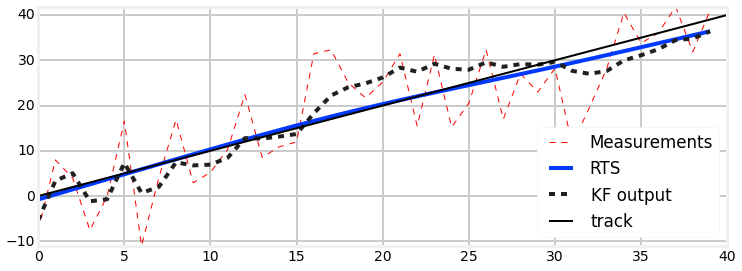

In [5]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
import book_plots as bp

def plot_rts(noise):
    random.seed(123)
    fk = KalmanFilter(dim_x=2, dim_z=1)

    fk.x = np.array([0., 1.])      # initial state (location and velocity)

    fk.F = np.array([[1., 1.],
                     [0., 1.]])    # state transition matrix

    fk.H = np.array([[1., 0.]])    # Measurement function
    fk.P = 10.                     # covariance matrix
    fk.R = noise                   # state uncertainty
    fk.Q = 0.001                   # process uncertainty

    # create noisy data
    zs = np.asarray([t + random.randn()*noise for t in range (40)])

    # filter data with Kalman filter, than run smoother on it
    mu, cov, _, _ = fk.batch_filter(zs)
    M,P,C = fk.rts_smoother(mu, cov)

    # plot data
    bp.plot_measurements(zs, lw=1)
    plt.plot(M[:, 0], c='b', label='RTS')
    plt.plot(mu[:, 0], c='g', linestyle='--', label='KF output')
    plt.plot([0, len(zs)], [0, len(zs)], 'k', linewidth=2, label='track') 
    plt.legend(loc=4)
    plt.show()
    
plot_rts(7.)

I've injected a lot of noise into the signal to allow you to visually distinguish the RTS output from the ideal output. In the graph above we can see that the Kalman filter, drawn as the green dotted line, is reasonably smooth compared to the input, but it still wanders from from the ideal line when several measurements in a row are biased towards one side of the line. In contrast, the RTS output is both extremely smooth and very close to the ideal output.

With a perhaps more reasonable amount of noise we can see that the RTS output nearly lies on the ideal output. The Kalman filter output, while much better, still varies by a far greater amount.

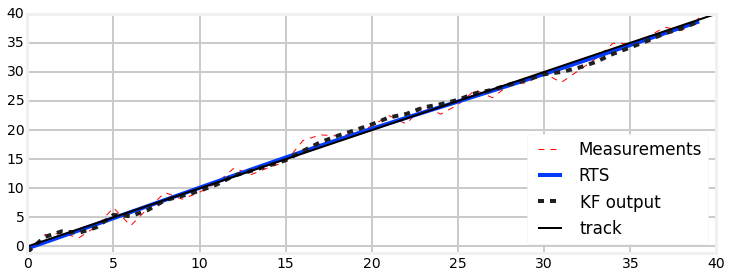

In [6]:
plot_rts(noise=1.)

## References

[1] H. Rauch, F. Tung, and C. Striebel. "Maximum likelihood estimates of linear dynamic systems," *AIAA Journal*, **3**(8), pp. 1445-1450 (August 1965).

http://arc.aiaa.org/doi/abs/10.2514/3.3166